In [1]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [2]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [3]:
import numpy as np

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 130MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 9.31MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 92.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.57MB/s]


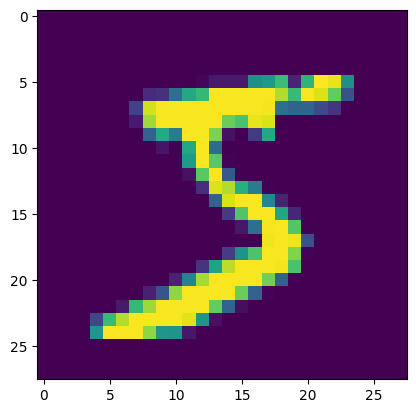

In [5]:
import matplotlib.pyplot as plt

plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

Попробуем использовать в качестве оптимизатора Adam, а для функции потерь оставим cross_entropy, но введём параметр сглаживания label_smoothing.

In [6]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train, label_smoothing=0.1)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val, label_smoothing=0.1)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [10]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 57.17it/s]


Epoch: 0, loss: 0.616422712802887, accuracy: 0.9725


100%|██████████| 157/157 [00:02<00:00, 61.30it/s]


Epoch: 2, loss: 0.5932413339614868, accuracy: 0.9791


100%|██████████| 157/157 [00:02<00:00, 61.33it/s]

Epoch: 4, loss: 0.590510368347168, accuracy: 0.9794


Как видно, baseline в 0.9747 уже преодолен. Попробуем ещё улучшить результат. Изменим немного архитектуру.

In [11]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 50.71it/s]


Epoch: 0, loss: 0.5990191698074341, accuracy: 0.9802


100%|██████████| 157/157 [00:03<00:00, 50.06it/s]


Epoch: 2, loss: 0.5638371706008911, accuracy: 0.9884


100%|██████████| 157/157 [00:03<00:00, 50.72it/s]

Epoch: 4, loss: 0.5532363653182983, accuracy: 0.9897


In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [15]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 49.66it/s]


Epoch: 0, loss: 0.553332507610321, accuracy: 0.9899


100%|██████████| 157/157 [00:03<00:00, 52.26it/s]


Epoch: 2, loss: 0.5491068959236145, accuracy: 0.9909


100%|██████████| 157/157 [00:03<00:00, 47.12it/s]

Epoch: 4, loss: 0.5444186329841614, accuracy: 0.9916


Здорово! Мы получили ещё больший скор. Попробуем уменьшить размер ядра.

In [16]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [18]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 44.55it/s]


Epoch: 0, loss: 0.6301711797714233, accuracy: 0.9707


100%|██████████| 157/157 [00:03<00:00, 46.63it/s]


Epoch: 2, loss: 0.5817397236824036, accuracy: 0.9836


100%|██████████| 157/157 [00:03<00:00, 39.82it/s]

Epoch: 4, loss: 0.5702000260353088, accuracy: 0.9848


Скор уменьшился. Попробуем вернуться к прошлой архитектуре и использовать другой оптимизатор.

In [19]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [21]:
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)

In [22]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 51.20it/s]


Epoch: 0, loss: 0.5906800627708435, accuracy: 0.9817


100%|██████████| 157/157 [00:03<00:00, 51.27it/s]


Epoch: 2, loss: 0.5593401193618774, accuracy: 0.9888


100%|██████████| 157/157 [00:03<00:00, 50.67it/s]

Epoch: 4, loss: 0.5514333248138428, accuracy: 0.9896


Результат улучшился, но не превзошёл лучший. Попробуем поменять параметр label_smoothing.

In [23]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train, label_smoothing=0.2)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val, label_smoothing=0.2)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [31]:
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)

In [27]:
train(model, optimizer)

100%|██████████| 157/157 [00:04<00:00, 38.73it/s]


Epoch: 0, loss: 0.9093651175498962, accuracy: 0.9901


100%|██████████| 157/157 [00:03<00:00, 44.89it/s]


Epoch: 2, loss: 0.907073974609375, accuracy: 0.9899


100%|██████████| 157/157 [00:03<00:00, 51.57it/s]

Epoch: 4, loss: 0.9049404859542847, accuracy: 0.9912


Теперь я хочу попробовать другие функции активации и пару разных оптимизаторов.

In [30]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ELU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ELU(),
    nn.Linear(128, 10)
)

In [32]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 46.73it/s]


Epoch: 0, loss: 0.9737525582313538, accuracy: 0.9784


100%|██████████| 157/157 [00:03<00:00, 46.93it/s]


Epoch: 2, loss: 0.9350653290748596, accuracy: 0.9872


100%|██████████| 157/157 [00:03<00:00, 43.09it/s]

Epoch: 4, loss: 0.9189772009849548, accuracy: 0.9903


In [38]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [39]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [40]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 47.55it/s]


Epoch: 0, loss: 0.9867804646492004, accuracy: 0.9679


100%|██████████| 157/157 [00:03<00:00, 48.89it/s]


Epoch: 2, loss: 0.9237945079803467, accuracy: 0.9891


100%|██████████| 157/157 [00:03<00:00, 50.06it/s]

Epoch: 4, loss: 0.9306233525276184, accuracy: 0.9871


In [41]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)

In [42]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 46.75it/s]


Epoch: 0, loss: 0.9111664295196533, accuracy: 0.9907


100%|██████████| 157/157 [00:03<00:00, 52.27it/s]


Epoch: 2, loss: 0.9106799364089966, accuracy: 0.9906


100%|██████████| 157/157 [00:03<00:00, 49.41it/s]

Epoch: 4, loss: 0.9104884266853333, accuracy: 0.9905


Как итог, лучший скор в 0.9916 получился с использованием AdamW(lr = 1e-3) и с использованием label_smoothing = 0.1. Как вариант, можно было попробовать ещё разные оптимизаторы, увеличить количество эпох, изменить шаг learning_rate, попробовать другие архитектуры, использовать аугментации. В целом, получился более чем удовлетворительный результат.